In [219]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [220]:
words = open("names.txt", "r").read().splitlines()

In [221]:
chars = sorted(list(set(''.join(words))))

stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [222]:
def build_dataset(words, block_size=3):

    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)

            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"{X.shape=}   {Y.shape=}")
    return X, Y

In [223]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size = 8

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xtest, Ytest = build_dataset(words[n2:], block_size)

X.shape=torch.Size([182625, 8])   Y.shape=torch.Size([182625])
X.shape=torch.Size([22655, 8])   Y.shape=torch.Size([22655])
X.shape=torch.Size([22866, 8])   Y.shape=torch.Size([22866])


In [224]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(f"{''.join(itos[xi] for xi in x.tolist())} -> {itos[y.item()]}")

........ -> y
.......y -> u
......yu -> h
.....yuh -> e
....yuhe -> n
...yuhen -> g
..yuheng -> .
........ -> d
.......d -> i
......di -> o
.....dio -> n
....dion -> d
...diond -> r
..diondr -> e
.diondre -> .
........ -> x
.......x -> a
......xa -> v
.....xav -> i
....xavi -> e


In [369]:
class Linear:
    def __init__(self, input_dim, output_dim, bias=True):
        
        self.training = True

        self.bias = bias
        self.W = torch.randn(input_dim, output_dim) * (input_dim**-0.5)
        if bias:
            self.b = torch.randn(1, output_dim) * 0.2

    def __call__(self, x):
        self.out = self.forward(x)
        return self.out
    
    def forward(self, x):
        out = x @ self.W
        if self.bias:
            out += self.b
        return out
    
    def parameters(self):
        return [self.W] + ([self.b] if self.bias else [])

######

class BatchNorm1d:
    def __init__(self, features_dim, eps=1e-5, momentum=0.05):

        self.training = True
        self.eps = eps
        self.momentum = momentum

        self.gamma = torch.ones(features_dim)
        self.beta = torch.zeros(features_dim)
        
        self.running_mean = torch.zeros(features_dim)
        self.running_var = torch.ones(features_dim)

    def __call__(self, x: torch.Tensor):
        self.out = self.forward(x)
        return self.out

    def forward(self, x: torch.Tensor):
        if self.training:
            mean = x.mean(dim=0, keepdim=True)
            var = x.var(dim=0, keepdim=True, unbiased=False)
            
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var

        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x_hat + self.beta

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def parameters(self):
        return [self.gamma, self.beta]

######    

class Tanh:
    def __init__(self):
        self.training = True

    def __call__(self, x: torch.Tensor):
        return self.forward(x)

    def forward(self, x: torch.Tensor):
        self.out = x.tanh()
        return self.out

    def parameters(self):
        
        return []
    
######

class Embedding:
    def __init__(self, num_emb, emb_dim):
        self.training = True
        self.W = torch.randn(num_emb, emb_dim)
    
    def __call__(self, ix):
        self.out = self.W[ix]
        return self.out
        
    def parameters(self):
        return [self.W]

######

class FlattenConsecutive:
    def __init__(self, n):
        self.training = True
        self.n = n

    def __call__(self, x):
        
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        # self.out = x.view(x.shape[0], -1, x.shape[2]*self.n) # same as above
        # self.out = x.view(x.shape[0], -1)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
######

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def train(self):
        for layer in self.layers:
            layer.training = True

    def eval(self):
        for layer in self.layers:
            layer.training = False

In [370]:
torch.manual_seed(42)

In [371]:
emb_dim = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, emb_dim),
    FlattenConsecutive(2), Linear(2 * emb_dim, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2 * n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2 * n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].W *= 0.1

params = model.parameters()
print("Number of params: ", sum(p.numel() for p in params))
for p in params:
    p.requires_grad = True

Number of params:  22397


In [372]:
# training:

model.train()

epochs = 200_000
b_size = 32
lossi = []
lr = 0.1

for i in range(0, epochs):

    xi = torch.randint(0, Xtr.shape[0], (b_size,))
    Xb, Yb = Xtr[xi], Ytr[xi]

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)
    for p in params:
        p.grad = None
    loss.backward()

    if i > 150_000:
        lr /= 10

    for p in params:
        p.data -= 0.1 * p.grad

    if i % (10_000) == 0:
        print(f"Epoch {i} -> Loss: {loss.item()}")
    lossi.append(loss.item())

Epoch 0 -> Loss: 3.3203608989715576
Epoch 10000 -> Loss: 1.821698784828186
Epoch 20000 -> Loss: 1.889836311340332
Epoch 30000 -> Loss: 2.069225788116455
Epoch 40000 -> Loss: 2.2287566661834717
Epoch 50000 -> Loss: 2.4098410606384277
Epoch 60000 -> Loss: 1.7031928300857544
Epoch 70000 -> Loss: 1.844218373298645
Epoch 80000 -> Loss: 2.6350059509277344
Epoch 90000 -> Loss: 2.1594622135162354
Epoch 100000 -> Loss: 1.9421494007110596
Epoch 110000 -> Loss: 2.0077645778656006
Epoch 120000 -> Loss: 1.7165312767028809
Epoch 130000 -> Loss: 2.1084752082824707
Epoch 140000 -> Loss: 1.738325834274292
Epoch 150000 -> Loss: 1.950108528137207
Epoch 160000 -> Loss: 2.1371421813964844
Epoch 170000 -> Loss: 1.6974819898605347
Epoch 180000 -> Loss: 2.2817370891571045
Epoch 190000 -> Loss: 2.3965697288513184


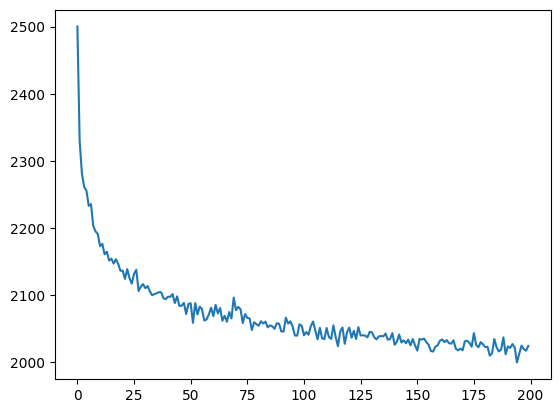

In [373]:
losst = torch.tensor(lossi).view(-1, 1_000).sum(dim=1)
plt.plot(losst);

In [374]:
model.eval()

@torch.no_grad()
def eval_model(split: str):

    Xv, Yv = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xtest, Ytest)
    }[split]

    logits = model(Xv)
    loss = F.cross_entropy(logits, Yv)
    return loss

eval_model('val')

tensor(2.0679)

In [218]:
model.eval()

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

ketise.
lyn.
akalla.
takelynn.
xovualarian.
ros.
kitian.
jayda.
samrue.
arroniya.
almary.
tayushaydhara.
vius.
alyanna.
faan.
reee.
omritta.
dayleigh.
gabbakaycui.
waliah.
